In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

% matplolib inline

UsageError: Line magic function `%` not found.


In [2]:
datawoman = pd.read_csv("mammographic_masses.data", header=None)
datawoman.head()

,0,1,2,3,4,5
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


## 1  Análise Exploratória de Dados


In [3]:
datawoman.head()

,0,1,2,3,4,5
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


In [4]:
#formato do dado
datawoman.shape

(961, 6)

In [5]:
#valores NA
datawoman.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [6]:
#Veja que não é verdade alguns dados apresentam ?  irei substituir pela mediana logo
for coluna in datawoman.columns:
    print(f'{coluna}: {datawoman[coluna].unique()}')

0: ['5' '4' '3' '?' '2' '55' '0' '6']
1: ['67' '43' '58' '28' '74' '65' '70' '42' '57' '60' '76' '64' '36' '54'
 '52' '59' '40' '66' '56' '75' '63' '45' '55' '46' '39' '81' '77' '48'
 '78' '50' '61' '62' '44' '23' '80' '53' '49' '51' '25' '72' '73' '68'
 '33' '47' '29' '34' '71' '84' '24' '86' '41' '87' '21' '19' '35' '37'
 '79' '85' '69' '38' '32' '27' '83' '88' '26' '31' '?' '18' '82' '93' '30'
 '22' '96' '20']
2: ['3' '1' '4' '?' '2']
3: ['5' '1' '?' '4' '3' '2']
4: ['3' '?' '1' '2' '4']
5: [1 0]


In [7]:
datawoman.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       961 non-null    object
 1   1       961 non-null    object
 2   2       961 non-null    object
 3   3       961 non-null    object
 4   4       961 non-null    object
 5   5       961 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 45.2+ KB


## 2 Pré-Processamento

In [8]:
#renomenado colunas sem nome
datawoman.columns = ["birads", "age", "shapemass", "margemass", "densidade", "gravidade"]

In [9]:
#mediana em dados que possuem valores ?
def aplicar_mediana():
    for coluna in datawoman.columns:
        moda = datawoman[coluna].mode()[0]
        datawoman[coluna] = datawoman[coluna].replace("?",moda)
aplicar_mediana()

In [10]:
def verificar_unicos():
    for coluna in datawoman.columns:
        print(f'{coluna}: {datawoman[coluna].unique()}')
verificar_unicos()

birads: ['5' '4' '3' '2' '55' '0' '6']
age: ['67' '43' '58' '28' '74' '65' '70' '42' '57' '60' '76' '64' '36' '54'
 '52' '59' '40' '66' '56' '75' '63' '45' '55' '46' '39' '81' '77' '48'
 '78' '50' '61' '62' '44' '23' '80' '53' '49' '51' '25' '72' '73' '68'
 '33' '47' '29' '34' '71' '84' '24' '86' '41' '87' '21' '19' '35' '37'
 '79' '85' '69' '38' '32' '27' '83' '88' '26' '31' '18' '82' '93' '30'
 '22' '96' '20']
shapemass: ['3' '1' '4' '2']
margemass: ['5' '1' '4' '3' '2']
densidade: ['3' '1' '2' '4']
gravidade: [1 0]


In [11]:
#codificando os dados em dummies
def muda_tipo():
    for coluna in datawoman.select_dtypes(include="object"):
        datawoman[coluna] = datawoman[coluna].astype("int32")
muda_tipo()

In [12]:
datawoman.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   birads     961 non-null    int32
 1   age        961 non-null    int32
 2   shapemass  961 non-null    int32
 3   margemass  961 non-null    int32
 4   densidade  961 non-null    int32
 5   gravidade  961 non-null    int64
dtypes: int32(5), int64(1)
memory usage: 26.4 KB


## 3 Separando previsores e classe e treino/teste

In [13]:
previsores = datawoman.iloc[:,0:5].values
classe =datawoman.iloc[:,5].values

In [14]:
X_train,X_test,y_train,y_test = train_test_split(previsores, classe, test_size=0.3, random_state=42)

## 4 Criação de Modelo e Predição

In [15]:
c1 = GaussianNB()
c2 = DecisionTreeClassifier(min_samples_leaf=6)
c3 = RandomForestClassifier(n_estimators=5000,random_state=42, min_samples_leaf=6)
c4 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.08, random_state=42, max_depth=4)
clfs =  [c1,c2,c3,c4]

def criador_modelo():
    for clf in clfs:
        modelo = clf.fit(X_train, y_train)
        previsao = modelo.predict(X_test)
        acuracia= accuracy_score(y_test, previsao)
        precisao = precision_score(y_test, previsao)
        revocacao = recall_score(y_test, previsao)
        f1score = f1_score(y_test, previsao)

        print(f"""
        Modelo: {clf}
        Acurácia: {acuracia}
        Precisão: {precisao}
        Recall: {revocacao}
        F1-score: {f1score}
        """)

criador_modelo()


        Modelo: GaussianNB()
        Acurácia: 0.8304498269896193
        Precisão: 0.8074074074074075
        Recall: 0.8257575757575758
        F1-score: 0.8164794007490637
        

        Modelo: DecisionTreeClassifier(min_samples_leaf=6)
        Acurácia: 0.8235294117647058
        Precisão: 0.8403361344537815
        Recall: 0.7575757575757576
        F1-score: 0.796812749003984
        

        Modelo: RandomForestClassifier(min_samples_leaf=6, n_estimators=5000, random_state=42)
        Acurácia: 0.8408304498269896
        Precisão: 0.8359375
        Recall: 0.8106060606060606
        F1-score: 0.8230769230769232
        

        Modelo: GradientBoostingClassifier(learning_rate=0.08, max_depth=4, n_estimators=1000,
                           random_state=42)
        Acurácia: 0.7889273356401384
        Precisão: 0.762962962962963
        Recall: 0.7803030303030303
        F1-score: 0.7715355805243446
        



        Modelo: GaussianNB()
        Acurácia: 0.8304498269896193
        Precisão: 0.8074074074074075
        Recall: 0.8257575757575758
        F1-score: 0.8164794007490637
        
Modelo:  fb260708d42348d09ae3c863667dd7f6

        Modelo: DecisionTreeClassifier(min_samples_leaf=6)
        Acurácia: 0.8235294117647058
        Precisão: 0.8403361344537815
        Recall: 0.7575757575757576
        F1-score: 0.796812749003984
        
Modelo:  fb260708d42348d09ae3c863667dd7f6

        Modelo: RandomForestClassifier(min_samples_leaf=6, n_estimators=5000, random_state=42)
        Acurácia: 0.8408304498269896
        Precisão: 0.8359375
        Recall: 0.8106060606060606
        F1-score: 0.8230769230769232
        
Modelo:  fb260708d42348d09ae3c863667dd7f6

        Modelo: GradientBoostingClassifier(learning_rate=0.09, max_depth=4, n_estimators=1000,
                           random_state=42)
        Acurácia: 0.7854671280276817
        Precisão: 0.7734375
        Recall: 0.75
       

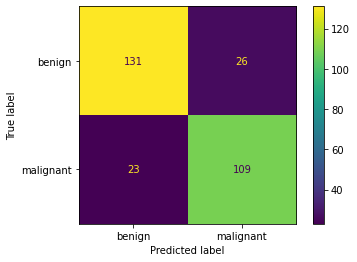

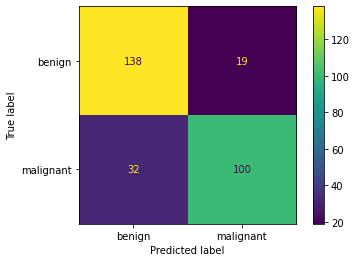

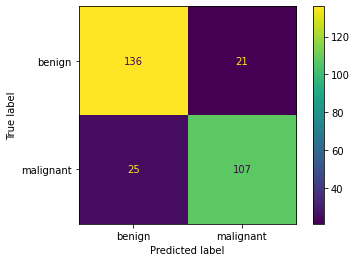

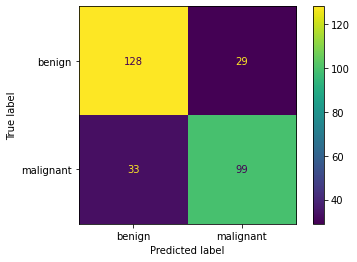

In [16]:

mlflow.set_experiment("Mamograph")
with mlflow.start_run():
    c1 = GaussianNB()
    c2 = DecisionTreeClassifier(min_samples_leaf=6)
    #estiamdor
    ms = 6
    c3 = RandomForestClassifier(n_estimators=5000,random_state=42, min_samples_leaf=6)
    #estimadores
    ne=1000
    mrs=6
    c4 = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.09, random_state=42, max_depth=4)
    #estimadores
    nxe=1000
    lr=0.01
    md=4

    clfs =  [c1,c2,c3,c4]
    contador=0
    contar=0
    for clf in clfs:
        modelo = clf.fit(X_train, y_train)
        previsao = modelo.predict(X_test)
        acuracia= accuracy_score(y_test, previsao)
        precisao = precision_score(y_test, previsao)
        revocacao = recall_score(y_test, previsao)
        f1score = f1_score(y_test, previsao)
        confusao = confusion_matrix(y_test, previsao)

        print(f"""
        Modelo: {clf}
        Acurácia: {acuracia}
        Precisão: {precisao}
        Recall: {revocacao}
        F1-score: {f1score}
        """)
        #parametros
        
        if contador==1:
            mlflow.log_param("min_samples_leaf", ms)
        elif contador ==2:
            mlflow.log_param("n_estimators", ne)
            mlflow.log_param("min_sampels_leaf", mrs)
            
        elif contador==3:
            mlflow.log_param("n_estimators", nxe)
            mlflow.log_param("learning_rate", lr)
            mlflow.log_param("max-depth", md)
        contador+=1
        
        categorias = ["benign", "malignant"]
        confusao = ConfusionMatrixDisplay(confusao,display_labels=categorias)
        confusao.plot()
        plt.savefig("confusao.png")
        mlflow.log_artifact("confusao.png")


        #metricas
        mlflow.log_metric("acuracia", acuracia)
        mlflow.log_metric("precisao", precisao)
        mlflow.log_metric("recall", revocacao)
        mlflow.log_metric("f1score", f1score)


        #salvando imagens
       
      
        #modelo
        
        cla = ["NaiveBayes", "DecisionTress", "RandomForest", "GradientBoost"]
    
        mlflow.sklearn.log_model(modelo,cla[contar])
        print("Modelo: ", mlflow.active_run().info.run_uuid)
        contar+=1

mlflow.end_run()

## Referências

https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass